In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import bayesnet as bn

np.random.seed(1111)

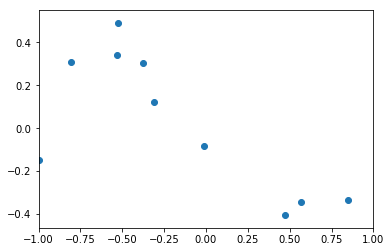

In [2]:
x_train = np.random.uniform(-1, 1, 10)
X_train = PolynomialFeatures(3).fit_transform(x_train[:, None])
y_train = X_train @ np.array([0., -1., 0., 1.]) + np.random.normal(scale=0.1, size=x_train.size)

plt.scatter(x_train, y_train)
plt.xlim(-1, 1)
plt.show()

In [3]:
class LinearRegressor(bn.Network):
    
    def __init__(self, degree):
        super().__init__(
            w=np.zeros(degree + 1)
        )
        
    def __call__(self, x, y=None):
        self.py = bn.random.MultivariateGaussian((x * self.w).sum(axis=-1), np.eye(x.shape[0]), data=y)
        return self.py.mu.value

In [4]:
model = LinearRegressor(3)
optimizer = bn.optimizer.Adam(model, 1e-3)

for _ in range(10000):
    model.clear()
    model(X_train, y_train)
    log_likelihood = model.log_pdf()
    log_likelihood.backward()
    optimizer.update()

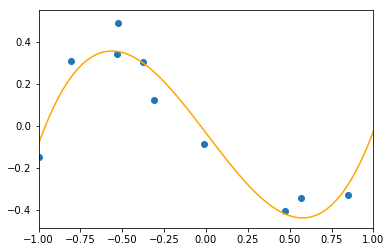

In [5]:
x = np.linspace(-1, 1, 100)
X = PolynomialFeatures(3).fit_transform(x[:, None])

y = model(X)
plt.scatter(x_train, y_train)
plt.plot(x, y, color="orange")
plt.xlim(-1, 1)
plt.show()

In [6]:
class BayesianLinearRegressor(bn.Network):
    
    def __init__(self, degree):
        super().__init__(
            w_mu=np.zeros(degree + 1),
            w_cov=np.eye(degree + 1)
        )
        
    def __call__(self, x, y=None):
        self.qw = bn.random.MultivariateGaussian(
            self.w_mu, self.w_cov @ self.w_cov.transpose(),
            p=bn.random.MultivariateGaussian(np.zeros(self.w_mu.size), np.eye(self.w_mu.size))
        )
        self.py = bn.random.MultivariateGaussian((x * self.qw.draw()).sum(axis=-1), 0.1 * np.eye(x.shape[0]), data=y)
        if y is None:
            return self.py.draw().value

In [7]:
model = BayesianLinearRegressor(3)
optimizer = bn.optimizer.Adam(model, 1e-3)

for _ in range(10000):
    model.clear()
    model(X_train, y_train)
    elbo = model.elbo()
    elbo.backward()
    optimizer.update()

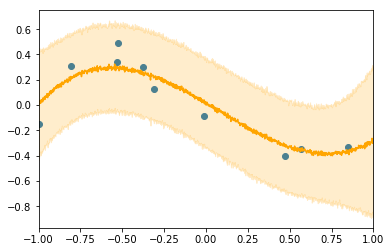

In [8]:
x = np.linspace(-1, 1, 1000)
X = PolynomialFeatures(3).fit_transform(x[:, None])

y = [model(X) for _ in range(1000)]
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)
plt.scatter(x_train, y_train)
plt.plot(x, y_mean, color="orange")
plt.fill_between(x, y_mean - y_std, y_mean + y_std, color="orange", alpha=0.2)
plt.xlim(-1, 1)
plt.show()

In [9]:
class AnalyticalBayesianLinearRegression(object):
    
    def __init__(self, alpha=1.0, beta=1.0):
        self.alpha = alpha
        self.beta = beta
        
    def fit(self, X, y):
        self.w_cov = np.linalg.inv(self.alpha * np.eye(X.shape[1]) + self.beta * X.T @ X)
        self.w_mean = self.beta * self.w_cov @ X.T @ y
        
    def predict(self, X):
        y_mean = X @ self.w_mean
        y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=-1)
        return y_mean, y_var

In [10]:
model = AnalyticalBayesianLinearRegression(alpha=1., beta=10.)
model.fit(X_train, y_train)

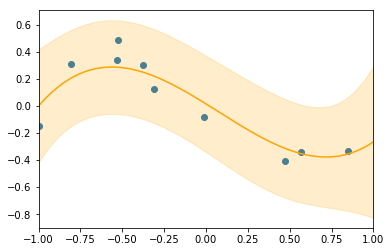

In [11]:
x = np.linspace(-1, 1, 1000)
X = PolynomialFeatures(3).fit_transform(x[:, None])

y_mean, y_var = model.predict(X)
y_std = np.sqrt(y_var)
plt.scatter(x_train, y_train)
plt.plot(x, y_mean, color="orange")
plt.fill_between(x, y_mean - y_std, y_mean + y_std, color="orange", alpha=0.2)
plt.xlim(-1, 1)
plt.show()